# Training and hosting SageMaker Models using the Apache MXNet Module API

The **SageMaker Python SDK** makes it easy to train and deploy MXNet models. In this example, we train a simple neural network using the Apache MXNet [Module API](https://mxnet.incubator.apache.org/api/python/module.html) and the MNIST dataset. The MNIST dataset is widely used for handwritten digit classification, and consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). The task at hand is to train a model using the 60,000 training images and subsequently test its classification accuracy on the 10,000 test images.


In [65]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker-ml-hw8-zqy'

## Data ingestion
Next, we read the dataset from the existing repository into memory, for preprocessing prior to training. In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits. For more details, please see here.

This processing could be done in situ by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [66]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 872 ms, sys: 304 ms, total: 1.18 s
Wall time: 3.13 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

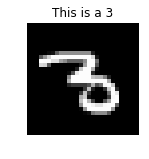

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### Setup

First define a few variables that will be needed later in the example.

In [68]:
from sagemaker import get_execution_role

#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://sagemaker-ml-hw8-zqy/customcode/mxnet'

#Bucket location where results of model training are saved.
model_artifacts_location = 's3://sagemaker-ml-hw8-zqy/artifacts'

#IAM execution role that gives SageMaker access to resources in your AWS account.
#We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

### The training script

The ``mnist.py`` script provides all the code we need for training and hosting a SageMaker model. The script we will use is adaptated from Apache MXNet.

In [69]:
!cat mnist.py

import logging

import gzip
import mxnet as mx
import numpy as np
import os
import struct


def load_data(path):
    with gzip.open(find_file(path, "labels.gz")) as flbl:
        struct.unpack(">II", flbl.read(8))
        labels = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(find_file(path, "images.gz")) as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(labels), rows, cols)
        images = images.reshape(images.shape[0], 1, 28, 28).astype(np.float32) / 255
    return labels, images


def find_file(root_path, file_name):
    for root, dirs, files in os.walk(root_path):
        if file_name in files:
            return os.path.join(root, file_name)


def build_graph():
    data = mx.sym.var('data')
    data = mx.sym.flatten(data=data)
    fc1 = mx.sym.FullyConnected(data=data, num_hidden=128)
    act1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc2 = mx.sym.FullyConnect

### SageMaker's MXNet estimator class

The SageMaker ```MXNet``` estimator allows us to run single machine or distributed training in SageMaker, using CPU or GPU-based instances.

When we create the estimator, we pass in the filename of our training script, the name of our IAM execution role, and the S3 locations we defined in the setup section. We also provide a few other parameters. ``train_instance_count`` and ``train_instance_type`` determine the number and type of SageMaker instances that will be used for the training job. The ``hyperparameters`` parameter is a ``dict`` of values that will be passed to your training script -- you can see how to access these values in the ``mnist.py`` script above.

For this example, we will choose one ``ml.m4.xlarge`` instance.

In [70]:
from sagemaker.mxnet import MXNet

mnist_estimator = MXNet(entry_point='mnist.py',
                        role=role,
                        output_path=model_artifacts_location,
                        code_location=custom_code_upload_location,
                        train_instance_count=1, 
                        train_instance_type='ml.m4.xlarge',
                        hyperparameters={'learning_rate': 0.1})

### Running the Training Job

After we've constructed our MXNet object, we can fit it using data stored in S3. Below we run SageMaker training on two input channels: **train** and **test**.

During training, SageMaker makes this data stored in S3 available in the local filesystem where the mnist script is running. The ```mnist.py``` script simply loads the train and test data from disk.

In [72]:
%%time
import boto3

region = boto3.Session().region_name
train_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/train'.format(region)
test_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/test'.format(region)

mnist_estimator.fit({'train': train_data_location, 'test': test_data_location})

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-cpu-2018-03-09-07-03-40-344


......................................................................
executing startup script (first run)
2018-03-09 07:09:03,274 INFO - root - running container entrypoint
2018-03-09 07:09:03,274 INFO - root - starting train task
2018-03-09 07:09:04,769 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mnist.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/op

2018-03-09 07:09:21,718 INFO - root - Epoch[7] Batch [400]#011Speed: 41194.17 samples/sec#011accuracy=0.971400
2018-03-09 07:09:21,963 INFO - root - Epoch[7] Batch [500]#011Speed: 40924.87 samples/sec#011accuracy=0.971300
2018-03-09 07:09:22,259 INFO - root - Epoch[7] Train-accuracy=0.969596
2018-03-09 07:09:22,259 INFO - root - Epoch[7] Time cost=1.548
2018-03-09 07:09:22,384 INFO - root - Epoch[7] Validation-accuracy=0.966200
2018-03-09 07:09:22,634 INFO - root - Epoch[8] Batch [100]#011Speed: 40401.29 samples/sec#011accuracy=0.974653
2018-03-09 07:09:22,878 INFO - root - Epoch[8] Batch [200]#011Speed: 41006.65 samples/sec#011accuracy=0.971400
2018-03-09 07:09:23,122 INFO - root - Epoch[8] Batch [300]#011Speed: 41066.60 samples/sec#011accuracy=0.974300
2018-03-09 07:09:23,497 INFO - root - Epoch[8] Batch [400]#011Speed: 26678.62 samples/sec#011accuracy=0.975500
2018-03-09 07:09:23,819 INFO - root - Epoch[8] Batch [500]#011Speed: 31009.20 samples/sec#011accuracy=0.975200
2018-03-09 07

2018-03-09 07:09:45,502 INFO - root - Epoch[19] Batch [200]#011Speed: 30103.70 samples/sec#011accuracy=0.994400
2018-03-09 07:09:45,868 INFO - root - Epoch[19] Batch [300]#011Speed: 27365.32 samples/sec#011accuracy=0.995400
2018-03-09 07:09:46,248 INFO - root - Epoch[19] Batch [400]#011Speed: 26328.12 samples/sec#011accuracy=0.994400
2018-03-09 07:09:46,571 INFO - root - Epoch[19] Batch [500]#011Speed: 30949.59 samples/sec#011accuracy=0.994600
2018-03-09 07:09:46,871 INFO - root - Epoch[19] Train-accuracy=0.994949
2018-03-09 07:09:46,871 INFO - root - Epoch[19] Time cost=2.016
2018-03-09 07:09:47,028 INFO - root - Epoch[19] Validation-accuracy=0.973200
2018-03-09 07:09:47,370 INFO - root - Epoch[20] Batch [100]#011Speed: 29511.23 samples/sec#011accuracy=0.995941
2018-03-09 07:09:47,695 INFO - root - Epoch[20] Batch [200]#011Speed: 30800.61 samples/sec#011accuracy=0.995400
2018-03-09 07:09:48,002 INFO - root - Epoch[20] Batch [300]#011Speed: 32564.80 samples/sec#011accuracy=0.995900
201

### Creating an inference Endpoint

Now, we can deploy the model we just trained behind a real-time hosted endpoint.  This next step can take, on average, 7 to 11 minutes to complete

After training, we use the ``MXNet estimator`` object to build and deploy an ``MXNetPredictor``. This creates a Sagemaker **Endpoint** -- a hosted prediction service that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances. Here we will deploy the model to a single ``ml.m4.xlarge`` instance.

In [73]:
%%time

predictor = mnist_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-cpu-2018-03-09-07-03-40-344
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-cpu-2018-03-09-07-03-40-344


---------------------------------------------------------------------------------------------------------------!CPU times: user 468 ms, sys: 32 ms, total: 500 ms
Wall time: 9min 27s


The request handling behavior of the Endpoint is determined by the ``mnist.py`` script. In this case, the script doesn't include any request handling functions, so the Endpoint will use the default handlers provided by SageMaker. These default handlers allow us to perform inference on input data encoded as a multi-dimensional JSON array.

### Making an inference request

Now that our Endpoint is deployed and we have a ``predictor`` object, we can use it to classify handwritten digits.

To see inference in action, draw a digit in the image box below. The pixel data from your drawing will be loaded into a ``data`` variable in this notebook. 

*Note: after drawing the image, you'll need to move to the next notebook cell.*

In [74]:
from IPython.display import HTML
HTML(open("input.html").read())

In [75]:
response = predictor.predict(data)
print('Raw prediction result:')
print(response)

labeled_predictions = list(zip(range(10), response[0]))
print('Labeled predictions: ')
print(labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print('Most likely answer: {}'.format(labeled_predictions[0]))

NameError: name 'data' is not defined

Now we can use the ``predictor`` object to classify the handwritten digit:

# (Optional) Delete the Endpoint

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [56]:
print("Endpoint name: " + predictor.endpoint)

Endpoint name: sagemaker-mxnet-py2-cpu-2018-03-09-05-24-53-301


In [57]:
import sagemaker

sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-py2-cpu-2018-03-09-05-24-53-301
